# PSI Numerical Methods 2024 - Homework Assignment on Model Fitting & MCMC

We're going to put together everything we have learned so far to re-do the data analysis for the
Perlmutter et al. 1999 paper on the discovery of dark energy!  (https://ui.adsabs.harvard.edu/abs/1999ApJ...517..565P/abstract)

Start by `Forking` this repository on Github: https://github.com/dstndstn/PSI-Numerical-Methods-2024-MCMC-Homework
And then clone the repository to your laptop or to Symmetry.
You can modify this notebook, and when you are done, save it, and then `git commit -a` the results,
and `git push` them back to your fork of the repository.  You will "hand in" your homework by giving
a link to your Github repository, where the marker will be able to read your notebook.

First, a little bit of background on the cosmology and astrophysics.  The paper reports measurements
of a group of supernova explosions of a specific type, "Type 1a".  These are thought to be caused by
a white dwarf star that has a companion star that "donates" gas to the white dwarf.  It gradually gains
mass until it exceeds the Chandresekhar mass, and explodes.  Since they all explode through the same
mechanism, and with the same mass, they should all have the same intrinsic brightess.  It turns out to
be a _little_ more complicated than that, but in the end, these Type-1a supernovae can be turned into
"standard candles", objects that are all the same brightness.  If you can also measure the redshift of
each galaxy containing the supernova, then you can map out this brightness--redshift relation, and the
shape of that relation depends on how the universe grows over cosmic time.  In turn, the growth rate of
the universe depends on the contents of the universe!

In this way, these Type-1a supernova allow us to constrain the parameters of a model of the universe.
Specifically, the model is called "Lambda-CDM", a universe containing dark energy and matter (cold dark matter,
plus regular matter).  We will consider a two-parameter version of this model: $\Omega_M$, the
amount of matter, and $\Omega_{\Lambda}$, the amount of dark energy.  These are in cosmology units of
"energy density now relative to the critical density", where the critical density is the energy density you need
for the universe to be spatially flat (angles of a large triangle sum to 180 degrees).
So $\Omega_M = 1$, $\Omega_{\Lambda} = 0$ would be a flat universe containing all matter, while
$\Omega_M = 0.25$, $\Omega_{\Lambda} = 0.5$ would be a spatially closed universe with dark energy and matter.
Varying these ingredients changes the growth history of the universe, which changes how much the light from a
supernova is redshifted, and how its brightness drops off with distance.

(In the code below, we will call these `Omega_M` = $\Omega_M$ and `Omega_DE` = $\Omega_{\Lambda}$.)

Distance measurements in cosmology are complicated -- see https://arxiv.org/abs/astro-ph/9905116 for details!
For this assignment, we will use a cosmology package that will handle all this for us.  All we need to use is
the "luminosity distance", which is the one that tells you how objects get fainter given a redshift.

In [1]:
# Let's start by installing the Cosmology package!
using Pkg
Pkg.add("Cosmology")

    Updating registry at `C:\Users\ypanahi\.julia\registries\General.toml`
   Resolving package versions...
   Installed Cosmology ───── v1.0.2
   Installed UnitfulAngles ─ v0.6.2
   Installed UnitfulAstro ── v1.2.0
    Updating `C:\Users\ypanahi\.julia\environments\v1.9\Project.toml`
  [76746363] + Cosmology v1.0.2
    Updating `C:\Users\ypanahi\.julia\environments\v1.9\Manifest.toml`
  [76746363] + Cosmology v1.0.2
⌅ [6fb2a4bd] + UnitfulAngles v0.6.2
  [6112ee07] + UnitfulAstro v1.2.0
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
Precompiling project...
  ✓ UnitfulAngles
  ✓ UnitfulAstro
  ✓ Cosmology
  3 dependencies successfully precompiled in 32 seconds. 400 already precompiled.


In [1]:
# We'll also end up using all our old friends:
using WGLMakie
using CSV
using DataFrames
using Cosmology
using Statistics

In [2]:
# There is a data file in this directory, taken basically straight out of the Perlmutter+1999 paper.  We can read it with the CSV package.
data = CSV.read("p99-data.txt", DataFrame, delim=" ", ignorerepeated=true);

In [3]:
data

Row,SNname,z,sigma_z,m_x_peak,sigma_x_peak,A_x,K_bx,m_b_peak,m_b_eff,sigma_m_b_eff
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1992bi,0.458,0.001,22.12,0.1,0.03,-0.72,22.81,23.11,0.46
2,1994F,0.354,0.001,22.08,0.1,0.11,-0.58,22.55,22.38,0.33
3,1994G,0.425,0.001,21.52,0.21,0.03,-0.68,22.17,22.13,0.49
4,1994H,0.374,0.001,21.28,0.06,0.1,-0.61,21.79,21.72,0.22
5,1994al,0.42,0.001,22.37,0.06,0.42,-0.68,22.63,22.55,0.25
6,1994am,0.372,0.001,21.82,0.07,0.1,-0.61,22.32,22.26,0.2
7,1994an,0.378,0.001,22.14,0.08,0.21,-0.62,22.55,22.58,0.37
8,1995aq,0.453,0.001,22.6,0.07,0.07,-0.71,23.24,23.17,0.25
9,1995ar,0.465,0.005,22.71,0.04,0.07,-0.71,23.35,23.33,0.3


In [4]:
# Make a copy of the data columns that we want to treat as the "y" measurements.
# These are the measured brightnesses, and their Gaussian uncertainties (standard deviations).
data.mag = data.m_b_eff
data.sigma_mag = data.sigma_m_b_eff;

In [5]:
f = Figure()
Axis(f[1,1], title="Perlmutter+99 Supernovae", xlabel="Redshift z", ylabel="m_B")
errorbars!(data.z, data.mag, data.sigma_mag)
scatter!(data.z, data.mag, markersize=5, color=:maroon)
f

In [6]:
# Here is how we will use the "cosmology" package.  This will create a cosmology "object" with the parameters we pass in.
# It does not take an Omega_Lambda parameter; instead, it takes Omega_Matter, and Omega_K (for "curvature"), where
# Omega_K = 1. - Omatter - Olambda.  We will also pass in "Tcmb=0", which tells it to ignore the effects of radiation.

universe = cosmology(OmegaK=0.1, OmegaM=0.4, Tcmb=0)
@show universe
@show universe.Ω_Λ;

universe = Cosmology.OpenLCDM{Float64}(0.69, 0.1, 0.5, 0.4, 0.0)
universe.Ω_Λ = 0.5


In [7]:
# We can then pass that "universe" object to other functions to compute things about it.  Basically the only one you'll
# need is this `distance_modulus`, which tell you, in _magnitudes_, how much fainter an object is at the given redshift,
# versus how faint it would be if it were 10 parsecs away.

function distance_modulus(universe, z)
    DL = luminosity_dist(universe, z)
    # DL is in Megaparsecs; the distance for absolute to observed mag is 10 pc.
    5. * log10.(DL.val * 1e6 / 10.)
end;

There is one more parameter to the model we will be fitting: $M$, the _absolute magnitude_ of the supernovae.  This is a
"nuisance parameter" - a parameter that we have to fit for, but that we don't really care about; it's basically a calibration
of what the intrinsic brightness of a supernova is.  To start out, we will fix this value to a constant, but later we will
fit for it along with our Omegas.

The _observed_ brightness of a supernova will be its _absolute mag_ plus its _distance modulus_.  The _distance modulus_ depends on
the redshift _z_ and our parameters Omega_M and Omega_DE.

In [8]:
# We'll cheat a bit and use a "nominal" cosmology with currently-accepted values of Omega_M = 0.29, Omega_DE = 0.71.
nominal = cosmology(Tcmb=0)

f = Figure()
ax = Axis(f[1,1], title="Perlmutter+99 Supernovae", xlabel="Redshift z", ylabel="Observed mag")
errorbars!(data.z, data.mag, data.sigma_mag)
scatter!(data.z, data.mag, markersize=5, color=:maroon)

# Compute the average absolute magnitude M given nominal cosmology -- ie, an estimate of the absolute mag of the supernovae
DLx = map(z->distance_modulus(nominal, z), data.z)
abs_mag = median(data.mag - DLx)

# Here's another way to plot a function evaluated on a grid of values.
zgrid = 0.01:0.01:1.
DL = map(z->distance_modulus(nominal, z), zgrid)
lines!(zgrid, DL .+ abs_mag, label="Nominal OmegaM = 0.29, OmegaDE = 0.71")

universe = cosmology(OmegaK=0.0, OmegaM=0.6, Tcmb=0)
DL = map(z->distance_modulus(universe, z), zgrid)
lines!(zgrid, DL .+ abs_mag, color=:red, label="OmegaM = 0.6, OmegaDE = 0.4")

universe = cosmology(OmegaK=0.0, OmegaM=0.1, Tcmb=0)
DL = map(z->distance_modulus(universe, z), zgrid)
lines!(zgrid, DL .+ abs_mag, color=:green, label="OmegaM = 0.1, OmegaDE = 0.9")

#f[2,1] = Legend(f, ax, "Cosmologies", framevisible = false)
# Create a legend for our plot
axislegend(ax, position = :rb)
f

In [9]:
# Here's our scalar estimate of the absolute mag.
abs_mag

-19.228824925301424

## Part 1 - The Log-likelihood terrain

First, you have to write out the likelihood function for the observed supernova data, given cosmological model parameters.

That is, please complete the following function.  It will be passed vectors of `z`, `mag`, and `mag_error` measurements,
plus scalar parameters `M`, `Omega_M` and `Omega_DE`.  You will need to create a "cosmology" object, find the _distance modulus_ for
each redshift `z`, and add that to the absolute mag `M` to get the _predicted_ magnitude.  You will then compare that to each
measured magnitude, and compute the likelihood.

In [10]:
function supernova_log_likelihood(z, mag, mag_error, M, Omatter, Ode)
    # z: vector of redshifts
    # mag: vector of measured magnitudes
    # mag_error: vector of uncertainties on the measured magnitudes (sigmas).
    # M: scalar, absolute magnitude of a Type-1a supernova
    # Omatter: scalar Omega_M, amount of matter in the universe
    # Ode: scalar Omega_DE, amount of dark energy in the universe
    

    ###   MY CODE HERE!!
    
    universe = cosmology(OmegaK=1 - Omatter - Ode, OmegaM = Omatter, Tcmb=0);
    distnc_modul = map(z_i->distance_modulus(universe, z_i), z);
    
    y_pred = distnc_modul .+ M;
    y = mag;
    sigma_y = mag_error;
    chi = (y_pred .- y) ./ sigma_y;
    loglike = -0.5 .* chi .^ 2;

    # return a scalar value
    return sum(loglike)
end;

## Test the function:

In [11]:
M = abs_mag;
z = data.z;
mag = data.mag;
mag_error = data.sigma_mag;

n = 200;

ode_grid = LinRange(-1.5, 3, n);
om_grid = LinRange(0, 3, n);
sn_ll = zeros(n,n);

for i=1:n,j=1:n
    
    ll = 0;
    try
        ll = supernova_log_likelihood(data.z, data.mag, data.sigma_mag, abs_mag, om_grid[i], ode_grid[j])
    catch err
        ll = -Inf
    end
    sn_ll[i,j] = ll;

end

In [12]:
fig, ax , hm = heatmap(om_grid, ode_grid, sn_ll, colorrange=[maximum(sn_ll)-20, maximum(sn_ll)])
Colorbar(fig[:,end+1],hm)
fig

Next, please keep `M` fixed to the `abs_mag` value we computed above, and call your `supernova_log_likelihood` on a grid of
`Omega_M` and `Omega_DE` values.  (You will pass in `data.z`, `data.mag`, and `data.sigma_mag` for the `z`, `mag`, and `mag_error` values.)

Try a grid from 0 to 1 for both Omega_M and Omega_DE, and show the `supernova_log_likelihood` values using the `heatmap` function.
You may find it helpful to limit the range using something like `heatmap(om_grid, ode_grid, sn_ll, colorrange=[maximum(sn_ll)-20, maximum(sn_ll)])`.

Another thing you can do is, instead of showing the _log_-likelihood, show the likelihood by taking the `exp` of your `sn_ll` grid, like this, `heatmap(om_grid, ode_grid, exp.(sn_ll))`.

Please compare your plot to Figure 7 in the Perlmutter et al. 1999 paper, shown below.  Does your likelihood contour look consistent with the blue ellipses?

<img src="perlmutter-fig7.png" width="400"/>



Next, try expanding the grid ranges for Omega_M and Omega_DE up to, say, 0 to 2 or 0 to 3.  You should encounter a problem -- the cosmology package will fail to compute the `distance_modulus` for some combinations!  You can work around this by using Julia's `try...catch` syntax,
like this:

In [13]:
# Example of Julia's try-catch syntax:
try
    ll = supernova_log_likelihood(data.z, data.mag, data.sigma_mag, abs_mag, 2.0, 2.0)
catch err
    ll = -Inf
end

-72.35860296868422

This will "try" to run the `supernova_log_likelihood` function, and if it fails, it will go into the "catch" branch.

## Part 2 - Using MCMC to sample from the likelihood

Next, we will use Markov Chain Monte Carlo to draw samples from the likelihood distribution.

You can start with the `mcmc` function from the lecture.

You will need to tune the MCMC proposal's step sizes (also known as "jump sizes").  To do this, you can use
the variant of the `mcmc` routine that cycles through the parameters and only jumps one at a time, named
`mcmc_cyclic` in the updated lecture notebook.  After tuning the step sizes with `mcmc_cyclic`, you can go back
to the plain `mcmc` routine if you want, or stick with `mcmc_cyclic`; it is up to you.

Please plot the samples from your MCMC chains, to demonstrate that the chain looks like it has converged.  Ideally, you
would like to see reasonable acceptance rates, and you would like to see the samples "exploring" the parameter space.
Decide how many step you need to run the MCMC routine for, and write a sentence or two describing why you think that's
a good number.

For this part, please include the `M` (absolute magnitude) as a parameter that you are fitting -- so you are fitting for `M`
in addition to `Omega_M` and `Omega_DE`.  This is a quite standard situation where you have a "nuisance" parameter `M`
that you don't really care about, in addition to the `Omega` parameters that you do care about.

It is quite common to plot the results from an MCMC sampling using a "corner plot", which shows the distribution of
each of the individual parameters, and the joint distributions of pairs of parameters.  This will help you determine
whether some of the parameters are correlated with each other.

Below is a function you can use to generate corner plots from your chain -- call it like `cornerplot(chain, ["M", "Omega_M", "Omega_DE"])`.  There is also a CornerPlot package (https://juliapackages.com/p/cornerplot) but I have not had luck getting it
to work for me.

Once you have made you corner plots, please write a few sentences interpreting what you see.  Is the nuisance parameter `M` correlated with the Omegas?  Are the Omegas correlated with each other?

#### my comments: 
I just used the "propose" and "mcmc_cyclic" functions from the lecture's notebook, with one modification for the "mcmc_cyclic" fucntion.

In [14]:
function propose(p, jump_sizes)
    p .+ randn(length(p)) .* jump_sizes
end;

in the "mcmc_cyclic" function, I added "n_warmup" just to make sure that I am not making any measurements in the first few steps (as the values are yet to become stabalized). So, I am storing the results only after i>n_warmup steps has passed.

In [15]:
function mcmc_cyclic(logprob_func, propose_func, initial_p, n_steps, n_warmup)
    p = initial_p
    logprob = logprob_func(p)
    chain = zeros(n_steps-n_warmup, length(p))
    n_accept = zeros(length(p))

    for i in 1:n_steps

        # We're going to update one index at a time... 1, 2, 1, 2, ....
        update_index = 1 + ((i-1) % length(p))

        # Call the proposal function to generate new values for all parameters...
        p_prop = propose_func(p)
        # ... but then only keep one of the new parameter values!
        p_new = copy(p)
        p_new[update_index] = p_prop[update_index]
        
        logprob_new = logprob_func(p_new)

        ratio = exp(logprob_new - logprob)
        if ratio > 1
            # Jump to the new place
            p = p_new
            logprob = logprob_new
            n_accept[update_index] += 1
        else
            # Jump to the new place with probability "ratio"
            u = rand()
            if u < ratio
                # Jump to the new place
                p = p_new
                logprob = logprob_new
                n_accept[update_index] += 1
            else
                # Stay where we are
            end
        end
        if i > n_warmup
            chain[i-n_warmup, 1:end] = p
        end
    end
    # The number of times we step each parameter is roughly n_steps / n_parameters
    chain, n_accept ./ (n_steps ./ length(p))
end;

In [16]:
initial_guess = [-10,2.,2.]
jump_sizes = [0.5,0.1,0.1]

chain, accept_rate = mcmc_cyclic(p -> supernova_log_likelihood(data.z, data.mag, data.sigma_mag,p[1],p[2],p[3]),
    p -> propose(p, jump_sizes),
    initial_guess, 10000,1000)
@show accept_rate
@show size(chain)

accept_rate = [0.0765, 0.6696, 0.7149]
size(chain) = (9000, 3)


(9000, 3)

## results

In [17]:
chain[end,1] #absolute mag

-19.061375749673473

In [18]:
chain[end,2] #omega_m

0.3420077736603638

In [19]:
chain[end,3] #omega_de

0.25145374542039184

### how values change as a function of steps

In [20]:
using Plots

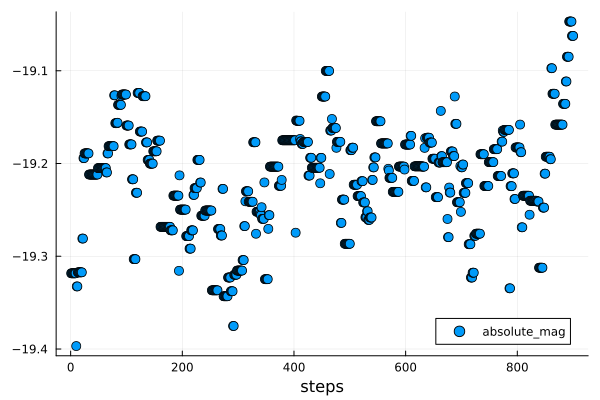

In [21]:
Plots.scatter(chain[1:10:end,1],xlabel = "steps",label="absolute_mag",markersize=5)

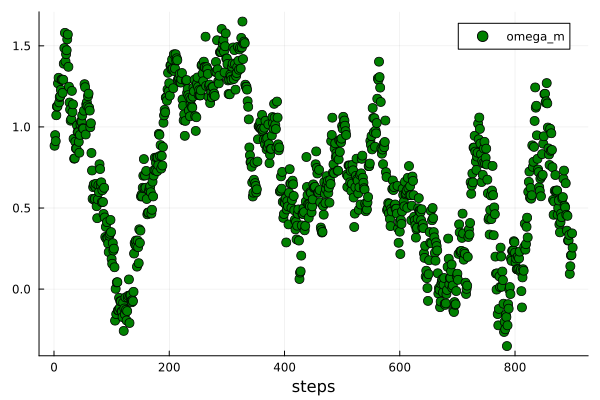

In [22]:
Plots.scatter(chain[1:10:end,2],xlabel = "steps",label="omega_m",markersize=5,color = :green)

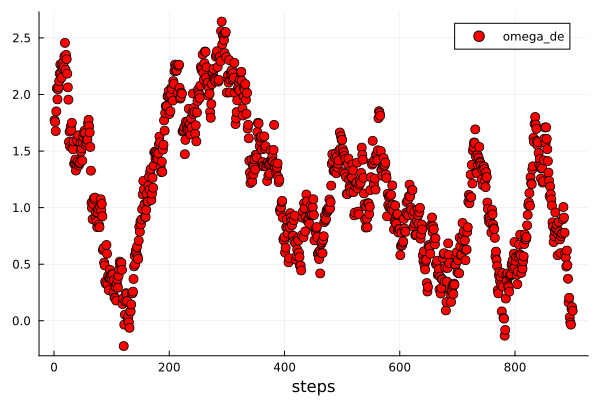

In [23]:
Plots.scatter(chain[1:10:end,3],xlabel = "steps",label="omega_de",markersize=5,color = :red)

In [24]:
function cornerplot(x, names; figsize=(800,800))
    # how many columns of data
    dim = size(x, 2)
    # rows to plot
    idxs = 1:size(x,1)
    f = Figure(size=figsize)
    for i in 1:dim, j in 1:dim
        if i < j
            continue
        end
        ax = Axis(f[i, j], aspect = 1,
                  topspinevisible = false,
                  rightspinevisible = false,)
        if i == j
            hist!(x[idxs,i], direction=:y)
            ax.xlabel = names[i]
        else
            #scatter!(x[idxs,j], x[idxs,i], markersize=4)
            WGLMakie.hexbin!(x[idxs,j], x[idxs,i])
            ax.xlabel = names[j]
            ax.ylabel = names[i]
        end
    end
    f
end;

Finally, please try to make a contour plot similar to Perlmutter et al.'s Figure 7.  From your MCMC chain, you can pull out the `Omega_M` and `Omega_DE` arrays, and then create a 2-d histogram.  Once you have a 2-d histogram, you can use the `contour` function to find and plot the contours in that histogram.

In [25]:
cornerplot(chain,["M","omega_m","omega_de"])

As we can see, M is not correlated with the Omegas but Omegas are correlated with each other.

In [26]:
omega_m = chain[:,2];
omega_de = chain[:,3];

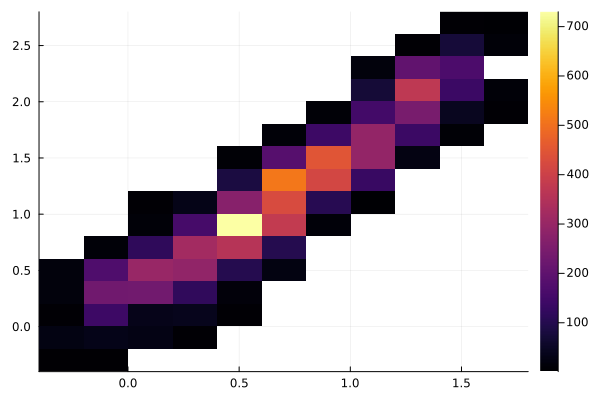

In [27]:
z = histogram2d(omega_m,omega_de)

In [28]:
import Pkg

In [29]:
Pkg.add("FHist")

   Resolving package versions...
  No Changes to `C:\Users\ypanahi\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\ypanahi\.julia\environments\v1.9\Manifest.toml`
Precompiling project...
  ✗ PyCall
  ✗ SciMLBase → SciMLBasePyCallExt
  ✗ PyPlot
  ✗ SymPy
  ✓ Plotly
  ✗ Symbolics → SymbolicsSymPyExt
  1 dependency successfully precompiled in 64 seconds. 465 already precompiled.
  5 dependencies errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the packages


In [31]:
using FHist

In [32]:
h2 = Hist2D((omega_m,omega_de),((0:0.1:2.0),(0:0.2:2.8)))

edges: (0.0:0.1:2.0, 0.0:0.2:2.8)
bin counts: [21 148 … 0 0; 12 83 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
total count: 8331

In [52]:
WGLMakie.contourf(0:0.1:1.9,0:0.2:2.79,bincounts(h2),color=:turbo)

As we can see, It is very similar to the heatmap we got previously.

Acknowledgment: I asked Nikhil for help on the intervals of my Hist2D fucntion, because I was getting some errors. He also introduced me to FHist Package. 